# This notebook is for the development of a pipeline for unsupervised learning on accelerometer data. 

## Pyhsmm is tested on the SMOVE dataset.

### Part 0: Imports

In [1]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import itertools
import math
import numpy as np
import pandas as pd
import pyhsmm
import pyhsmm.basic.distributions as distributions
from pyhsmm.util.text import progprint_xrange
from scipy import stats
import statistics 
from datetime import datetime

### Part 1: Data parsing

In [2]:
data_location = "/home/jack/data/SMOVE_acc_dataset_0.3"

# Creates strings for parsing over the file structure of the dataset
participant_IDs = ["p" + str(x) for x in range(2,10)]

In [3]:
# The data from each participant is stored into a dictionary
SMOVE_data = {}
for participant in participant_IDs:
    SMOVE_data[participant] = pd.read_pickle(r'{0}/{1}/acc_data.pickle'.format(data_location, participant))

In [4]:
# The data from the different devices are stored as a dictionary.
for device in SMOVE_data["p4"]:
    print(device)

# Example of the data from a device
SMOVE_data["p4"]["waist"]

waist
lower_back
left_wrist
right_wrist
left_upper_arm
right_upper_arm
left_shank
right_shank
left_thigh
right_thigh
sternum


timestamp      accX      accY      accZ  label
0             0.0 -9.739827 -0.326509 -0.939623    0.0
1            20.0 -9.744316 -0.382254 -0.979874    0.0
2            40.0 -9.730654 -0.277143 -0.950390    0.0
3            60.0 -9.700370 -0.358379 -1.060377    0.0
4            80.0 -9.673785 -0.349317 -1.056025    0.0
...           ...       ...       ...       ...    ...
258998  5179960.0 -9.638002 -0.670432 -1.535824    0.0
258999  5179980.0 -9.641184 -0.649248 -1.537786    0.0
259000  5180000.0 -9.627004 -0.655379 -1.457233    0.0
259001  5180020.0 -9.671665 -0.611618 -1.447346    0.0
259002  5180040.0 -9.641184 -0.630396 -1.531472    0.0

[259003 rows x 5 columns]

In [5]:
used_devices = ["right_thigh", "sternum", "left_thigh"]

### Part 1.5: Removing lab tasks

In [6]:
modified_SMOVE_data = {}
for participant in SMOVE_data:
    new_device_data = {}
    for device in SMOVE_data[participant]:
        data_copy = SMOVE_data[participant][device].copy()
        data_without_lab_tasks = data_copy[(data_copy.label != 0.0) & (data_copy.label != 1.0) & (data_copy.label != 2.0) & (data_copy.label != 3.0) & (data_copy.label != 4.0)]
        new_device_data[device] = data_without_lab_tasks
    modified_SMOVE_data[participant] = new_device_data

### Part 2: Basic plotting

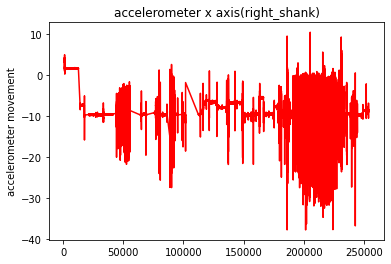

In [7]:
plt.plot(modified_SMOVE_data["p4"]["right_shank"]["accX"], color="red")
plt.title("accelerometer x axis(right_shank)")
plt.ylabel("accelerometer movement")
plt.show()

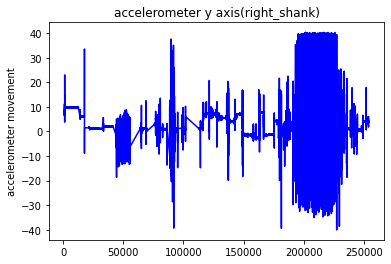

In [8]:
plt.plot(modified_SMOVE_data["p4"]["right_shank"]["accY"], color="blue")
plt.title("accelerometer y axis(right_shank)")
plt.ylabel("accelerometer movement")
plt.show()

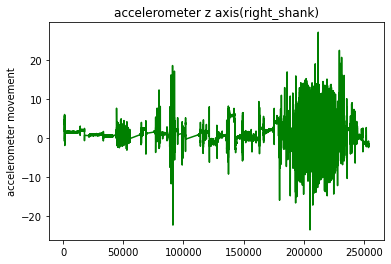

In [9]:
plt.plot(modified_SMOVE_data["p4"]["right_shank"]["accZ"], color="green")
plt.title("accelerometer z axis(right_shank)")
plt.ylabel("accelerometer movement")
plt.show()

### Part 3: Windows

The data of each participant is split into windows of a certain amount of seconds

In [10]:
def split_into_windows(data, nrows_per_window):
    # Splits input data into windows based on given amount of rows per window.
    return [data[i:i+nrows_per_window] for i in range(0,data.shape[0],nrows_per_window)]

In [11]:
# The sampling rate of the devices
hertz = 50
# the size of the windows in seconds
window_length = 5
nrows_per_window = int(window_length / (1 / hertz))

In [12]:
windowed_data = {}
all_windows_per_dev = {}
for participant in modified_SMOVE_data:
    windows_per_dev = {}
    for device in used_devices:
        windows = split_into_windows(modified_SMOVE_data[participant][device], nrows_per_window)
        windows_per_dev[device] =  windows
        
        try:
            all_windows_per_dev[device] +=  windows
        except KeyError:
            all_windows_per_dev[device] = windows.copy()
        
    windowed_data[participant] = windows_per_dev

### Part 4: Features

In [13]:
def calc_ENMO(x, y, z):
    # Returns the Euclidean Norm Minus One (ENMO). Calculated from three given values: X, Y and Z
    total_accel = math.sqrt(x**2 + y**2 + z**2)
    return np.clip(total_accel - 1, 0, None)


def calc_mean_ENMO(dataset):
    # Returns the mean total acceleration of a given set of data
    return statistics.mean(dataset.apply(lambda row: calc_ENMO(row["accX"],
                                                               row["accY"],
                                                               row["accZ"]), axis=1))


def calc_sensor_orientation(main_axis, second_axis, third_axis):
    # Returns the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return math.degrees(math.atan(main_axis / math.sqrt(second_axis**2 + third_axis**2)))


def calc_mean_sensor_orientation(dataset, main_axis, second_axis, third_axis):
    # Returns the mean the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return statistics.mean(dataset.apply(lambda row: calc_sensor_orientation(row["acc{}".format(main_axis)],
                                                                             row["acc{}".format(second_axis)],
                                                                             row["acc{}".format(third_axis)]), axis=1))


def extract_features(dataset):
    # returns the extracted features from the given dataset
    mean_ENMO = calc_mean_ENMO(dataset)
    mean_angle_x = calc_mean_sensor_orientation(dataset, "X", "Y", "Z")
    mean_angle_y = calc_mean_sensor_orientation(dataset, "Y", "X", "Z")
    mean_angle_z = calc_mean_sensor_orientation(dataset, "Z", "Y", "X")    
    return [mean_ENMO, mean_angle_x, mean_angle_y, mean_angle_z]


def get_minmax(input_list):
    # Returns the minimum and maximum of a given list
    return [min(input_list), max(input_list)]
    
    
def minmax_norm(x, xmin, xmax):
    # Normalizes data(x) using the min max approach, given the minimum and maximum of the total data
    return ((x - xmin) / (xmax - xmin))

In [14]:
# The minimum and maximum values of the features are calculated for each device.
# This is needed for min max normalization

min_max_data = {}

for device in all_windows_per_dev:
    print(datetime.now().strftime("%H:%M:%S"),"starting process of", device)
    device_windows = all_windows_per_dev[device]

    ENMO_list = [calc_mean_ENMO(window) for window in device_windows]
    angle_x_list = [calc_mean_sensor_orientation(window, "X", "Y", "Z") for window in device_windows]
    angle_y_list = [calc_mean_sensor_orientation(window, "Y", "X", "Z") for window in device_windows]
    angle_z_list = [calc_mean_sensor_orientation(window, "Z", "Y", "X") for window in device_windows]

    min_max_data[device+"min_ENMO"], min_max_data[device+"max_ENMO"] = get_minmax(ENMO_list)
    min_max_data[device+"min_angle_x"], min_max_data[device+"max_angle_x"] = get_minmax(angle_x_list)
    min_max_data[device+"min_angle_y"], min_max_data[device+"max_angle_y"] = get_minmax(angle_y_list)
    min_max_data[device+"min_angle_z"], min_max_data[device+"max_angle_z"] = get_minmax(angle_z_list)

16:30:07 starting process of right_thigh
16:33:20 starting process of sternum
16:36:30 starting process of left_thigh


In [15]:
features = {}
for participant in windowed_data:
    features_per_dev = {}
    for device in windowed_data[participant]:
        print(datetime.now().strftime("%H:%M:%S"), "starting process of", participant, "and",device)
        ENMO_list = []
        anglex_list = []
        angley_list = []
        anglez_list = []
        labels = []
        timestamps = []

        for window in windowed_data[participant][device]:
            # the label for the window is the mode of the labels in the window
            labels.append(stats.mode(window["label"].to_numpy())[0][0])
            # the timestamp for the window is the initial timestamp
            timestamps.append(window["timestamp"].iloc[0])

            enmo, anglex, angley, anglez = extract_features(window)

            ENMO_list.append(enmo)
            anglex_list.append(anglex)
            angley_list.append(angley)
            anglez_list.append(anglez)
        
        feature_data = {}
        feature_data["ENMO"] = [minmax_norm(ENMO, 
                                            min_max_data[device+"min_ENMO"], 
                                            min_max_data[device+"max_ENMO"]) for ENMO in ENMO_list]
        
        feature_data["anglex"] = [minmax_norm(anglex,
                                              min_max_data[device+"min_angle_x"],
                                              min_max_data[device+"max_angle_x"]) for anglex in anglex_list]
        
        feature_data["angley"] = [minmax_norm(angley,
                                              min_max_data[device+"min_angle_y"],
                                              min_max_data[device+"max_angle_y"]) for angley in angley_list]
        
        feature_data["anglez"] = [minmax_norm(anglez,
                                              min_max_data[device+"min_angle_z"],
                                              min_max_data[device+"max_angle_z"]) for anglez in anglez_list]
        feature_data["label"] = labels
        

        # The features are put into a new dataframe
        features_per_dev[device] = pd.DataFrame(feature_data, index= timestamps)

    features[participant] = features_per_dev
print(datetime.now().strftime("%H:%M:%S"), "done")

16:39:34 starting process of p2 and right_thigh
16:39:50 starting process of p2 and sternum
16:40:08 starting process of p2 and left_thigh
16:40:25 starting process of p3 and right_thigh
16:40:33 starting process of p3 and sternum
16:40:41 starting process of p3 and left_thigh
16:40:49 starting process of p4 and right_thigh
16:41:10 starting process of p4 and sternum
16:41:31 starting process of p4 and left_thigh
16:41:50 starting process of p5 and right_thigh
16:42:15 starting process of p5 and sternum
16:42:40 starting process of p5 and left_thigh
16:43:05 starting process of p6 and right_thigh
16:43:36 starting process of p6 and sternum
16:44:07 starting process of p6 and left_thigh
16:44:39 starting process of p7 and right_thigh
16:45:04 starting process of p7 and sternum
16:45:30 starting process of p7 and left_thigh
16:45:56 starting process of p8 and right_thigh
16:46:27 starting process of p8 and sternum
16:46:58 starting process of p8 and left_thigh
16:47:32 starting process o

### Combining the features of the devices

In [16]:
features_comb_devs = {}
labels = {}
for participant in features:
    feature_data = {}
    for device in features[participant]:
        feature_data[device+"_ENMO"] = features[participant][device]["ENMO"]
        feature_data[device+"_anglex"] = features[participant][device]["anglex"]
        feature_data[device+"_angley"] = features[participant][device]["angley"]
        feature_data[device+"_anglez"] = features[participant][device]["anglez"]
    labels["label"] = features[participant][used_devices[0]]["label"]
    features_comb_devs[participant] = pd.DataFrame(feature_data)

In [18]:
data_example = features["p4"]["sternum"]
data_example.head()

ENMO    anglex    angley    anglez  label
23000.0  0.460432  0.200444  0.206437  0.990792  100.0
28000.0  0.468736  0.191186  0.169003  0.993186  100.0
33000.0  0.465299  0.186551  0.168275  1.000000  100.0
38000.0  0.467057  0.183106  0.170118  0.998423  100.0
43000.0  0.467583  0.180697  0.167876  0.996639  100.0

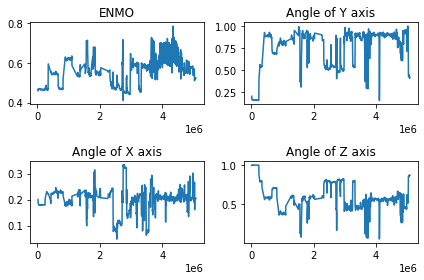

In [19]:
fig, ax = plt.subplots(2, 2)

ax[0,0].title.set_text('ENMO')
ax[0,0].plot(data_example["ENMO"])

ax[1,0].title.set_text('Angle of X axis')
ax[1,0].plot(data_example["anglex"])

ax[0,1].title.set_text('Angle of Y axis')
ax[0,1].plot(data_example["angley"])

ax[1,1].title.set_text('Angle of Z axis')
ax[1,1].plot(data_example["anglez"])

fig.tight_layout()

In [20]:
data_example

ENMO    anglex    angley    anglez  label
23000.0    0.460432  0.200444  0.206437  0.990792  100.0
28000.0    0.468736  0.191186  0.169003  0.993186  100.0
33000.0    0.465299  0.186551  0.168275  1.000000  100.0
38000.0    0.467057  0.183106  0.170118  0.998423  100.0
43000.0    0.467583  0.180697  0.167876  0.996639  100.0
...             ...       ...       ...       ...    ...
5059000.0  0.523027  0.200681  0.439203  0.853184  299.0
5064000.0  0.523320  0.202226  0.448432  0.847604  299.0
5069000.0  0.522787  0.202227  0.441446  0.851840  299.0
5074000.0  0.521933  0.204779  0.408977  0.871409  299.0
5079000.0  0.523340  0.205585  0.420276  0.864730  299.0

[811 rows x 5 columns]

In [21]:
# This is how data fend into the model looks like
data_example_no_labels = data_example.iloc[0:, 0:4]
data_example_no_labels.head()

ENMO    anglex    angley    anglez
23000.0  0.460432  0.200444  0.206437  0.990792
28000.0  0.468736  0.191186  0.169003  0.993186
33000.0  0.465299  0.186551  0.168275  1.000000
38000.0  0.467057  0.183106  0.170118  0.998423
43000.0  0.467583  0.180697  0.167876  0.996639

<AxesSubplot:>

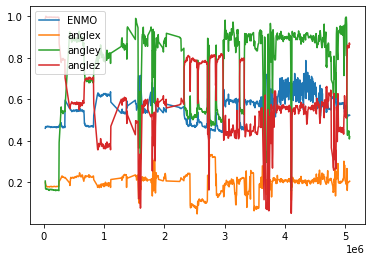

In [22]:
data_example_no_labels.plot()

### Part 5: PyHSMM testing

### Initial run

The parameters for this inital run follows what is recommended by the pyhsmm github.
Taken from examples/hsmm.py

In [78]:
# Dimension of the input data
obs_dim = len(features_comb_devs[participant_IDs[0]].columns)
# Max number of states generated
Nmax = 25

In [79]:
obs_hypparams = {'mu_0':np.zeros(obs_dim),
                'sigma_0':np.eye(obs_dim),
                'kappa_0':0.25,
                'nu_0':obs_dim+2}
dur_hypparams = {'alpha_0':2*30,
                 'beta_0':2}

In [80]:
obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

In [81]:
run1_posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns,
        dur_distns=dur_distns)

In [82]:
for participant in features_comb_devs:
    run1_posteriormodel.add_data(features_comb_devs[participant])

In [83]:
#for idx in progprint_xrange(150):
#    run1_posteriormodel.resample_model()

In [84]:
#plt.figure()
#run1_posteriormodel.plot()
#plt.gcf().suptitle('Sampled after 150 iterations')
#plt.show()

### Second run

lowered max number of states

In [85]:
Nmax = 30

obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

run2_posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns,
        dur_distns=dur_distns)

In [86]:
for participant in features_comb_devs:
    run2_posteriormodel.add_data(features_comb_devs[participant])

In [87]:
print(datetime.now().strftime("%H:%M:%S"), "Starting")
for idx in progprint_xrange(150):
    run2_posteriormodel.resample_model()
print(datetime.now().strftime("%H:%M:%S"), "Done")

19:42:24 Starting
.........................  [  25/150,    3.97sec avg, ETA 08:16 ]
.........................  [  50/150,    3.92sec avg, ETA 06:32 ]
.........................  [  75/150,    3.91sec avg, ETA 04:53 ]
.........................  [ 100/150,    3.91sec avg, ETA 03:15 ]
.........................  [ 125/150,    3.90sec avg, ETA 01:38 ]
.........................  [ 150/150,    3.90sec avg, ETA 0.00 ]

   3.90sec avg, 09:45 total

19:52:10 Done


<Figure size 432x288 with 0 Axes>

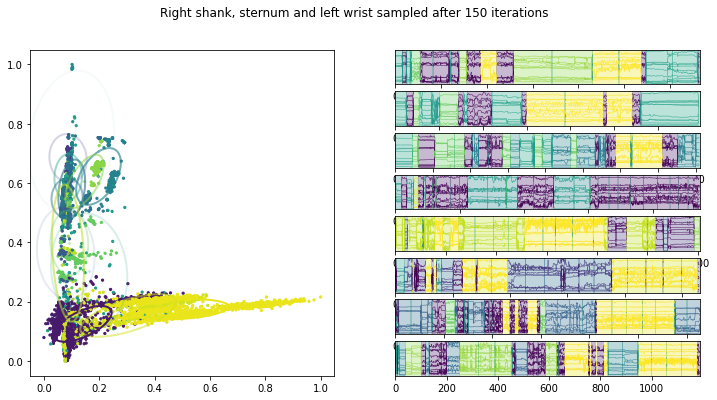

In [88]:
plt.figure()
run2_posteriormodel.plot()
plt.gcf().suptitle('Right shank, sternum and left wrist sampled after 150 iterations')
plt.show()

In [89]:
label_color_dict = {0.0 : "#E000FF",   # (Purple) Lab taks 
                    1.0 : "#BD00D7",   #   - 8m
                    2.0 : "#9E00B4",   #   - L-task
                    3.0 : "#830095",   #   - Irregular_walking
                    4.0 : "#630070",   #   - 8-task
                    100.0 : "#F4D4FF", # (pink) Lying
                    199.0 : "#F4D4FF", #   - Other_lying (ex. chekcing phone)
                    200.0 : "#0055FF", # (Blue) Sitting 
                    201.0 : "#0055FF", #    - Sitting_lying (couch)
                    219.0 : "#0055FF", #    - Sitting_lying_others
                    220.0 : "#0055FF", #    - Sitting_straight
                    221.0 : "#0055FF", #    - Eating 
                    222.0 : "#0055FF", #    - Sitting_cooking
                    223.0 : "#0055FF", #    - Playing_cards
                    224.0 : "#0055FF", #    - Computer_working
                    225.0 : "#0055FF", #    - Putting_shoes
                    226.0 : "#0055FF", #    - Checking_phone
                    299.0 : "#0055FF", #    - Sitting_others
                    300.0 : "#00F3FF", # (Cyan) Cycling
                    400.0 : "#13FF00", # (Green) Standing
                    401.0 : "#13FF00", #    - Standing_cooking
                    402.0 : "#13FF00", #    - Standing_holding_something
                    403.0 : "#13FF00", #    - Standing_getting_dress
                    499.0 : "#13FF00", #    - Standing_others
                    500.0 : "#FFF300", # (Yellow) Moving_around
                    501.0 : "#FFF300", #    - Cooking
                    502.0 : "#FFF300", #    - Doing_dishes
                    503.0 : "#FFF300", #    - Cleaning_floor
                    504.0 : "#FFF300", #    - Moving_carrying_something
                    505.0 : "#FFF300", #    - Opening_closing_door
                    599.0 : "#FFF300", #    - Moving_around_others
                    600.0 : "#FFAA00", # (Orange) Walking
                    601.0 : "#FFAA00", #    - Upstairs 
                    602.0 : "#FFAA00", #    - Downstairs
                    603.0 : "#FFAA00", #    - Walking_holding_something
                    604.0 : "#FFAA00", # ?
                    699.0 : "#FFAA00", #    - Walking_others
                    700.0 : "#FF0000", # (Red) Other activities
                    701.0 : "#FF0000", #    - Putting_pants_sitting_to_standing
                    702.0 : "#FF0000", #    - Putting_shoes_kneeling
                    800.0 : "#000000"} # (Black) Other events

In [90]:
label_dict = {0.0: 'Lab_tasks',
              1.0: '8m',
              2.0: 'L_task',
              3.0: 'Irregular_walking',
              4.0: '8_task',
              100.0: 'Lying',
              199.0: 'Other_lying',
              200.0: 'Sitting',
              201.0: 'Sitting_lying',
              219.0: 'Sitting_lying_others',
              220.0: 'Sitting_straight',
              221.0: 'Eating',
              222.0: 'Sitting_cooking',
              223.0: 'Playing_cards',
              224.0: 'Computer_working',
              225.0: 'Putting_shoes',
              226.0: 'Checking_phone',
              299.0: 'Sitting_others',
              300.0: 'Cycling',
              400.0: 'Standing',
              401.0: 'Standing_cooking',
              402.0: 'Standing_holding_something',
              403.0: 'Standing_getting_dress',
              499.0: 'Standing_others',
              500.0: 'Moving_around',
              501.0: 'Cooking',
              502.0: 'Doing_dishes',
              503.0: 'Cleaning_floor',
              504.0: 'Moving_carrying_something',
              505.0: 'Opening_closing_door',
              599.0: 'Moving_around_others',
              600.0: 'Walking', 
              601.0: 'Upstairs',
              602.0: 'Downstairs',
              603.0: 'Walking_holding_something',
              604.0: "Unkown_walking", # ?
              699.0: 'Walking_others',
              700.0: 'Other_activities',
              701.0: 'Putting_pants_sitting_to_standing',
              702.0: 'Putting_shoes_kneeling',
              800.0: 'Other_events'}

In [91]:
label_simplified_dict = {0.0 : "Lab_tasks",          # Lab tasks 
                         1.0 : "Lab_tasks",          #    - 8m
                         2.0 : "Lab_tasks",          #    - L-task
                         3.0 : "Lab_tasks",          #    - Irregular_walking
                         4.0 : "Lab_tasks",          #    - 8-task
                         100.0 : "Lying",            # Lying
                         199.0 : "Lying",            #    - Other_lying (ex. chekcing phone)
                         200.0 : "Sitting",          # Sitting 
                         201.0 : "Sitting",          #    - Sitting_lying (couch)
                         219.0 : "Sitting",          #    - Sitting_lying_others
                         220.0 : "Sitting",          #    - Sitting_straight
                         221.0 : "Sitting",          #    - Eating 
                         222.0 : "Sitting",          #    - Sitting_cooking
                         223.0 : "Sitting",          #    - Playing_cards
                         224.0 : "Sitting",          #    - Computer_working
                         225.0 : "Sitting",          #    - Putting_shoes
                         226.0 : "Sitting",          #    - Checking_phone
                         299.0 : "Sitting",          #    - Sitting_others
                         300.0 : "Cycling",          # Cycling
                         400.0 : "Standing",         # Standing
                         401.0 : "Standing",         #    - Standing_cooking
                         402.0 : "Standing",         #    - Standing_holding_something
                         403.0 : "Standing",         #    - Standing_getting_dress
                         499.0 : "Standing",         #    - Standing_others
                         500.0 : "Moving_around",    # Moving_around
                         501.0 : "Moving_around",    #    - Cooking
                         502.0 : "Moving_around",    #    - Doing_dishes
                         503.0 : "Moving_around",    #    - Cleaning_floor
                         504.0 : "Moving_around",    #    - Moving_carrying_something
                         505.0 : "Moving_around",    #    - Opening_closing_door
                         599.0 : "Moving_around",    #    - Moving_around_others
                         600.0 : "Walking",          # Walking
                         601.0 : "Walking",          #    - Upstairs 
                         602.0 : "Walking",          #    - Downstairs
                         603.0 : "Walking",          #    - Walking_holding_something
                         604.0 : "Walking", # ?
                         699.0 : "Walking",          #    - Walking_others
                         700.0 : "Other_activities", # Other activities
                         701.0 : "Other_activities", #    - Putting_pants_sitting_to_standing
                         702.0 : "Other_activities", #    - Putting_shoes_kneeling
                         800.0 : "Other_events"}     # Other events

In [92]:
state_color_dict = {"Walking" : "#FFAA00", # ORANGE
                    "Lying" : "#F4D4FF", # PINK
                    "Cycling" : "#00F3FF", # CYAN 
                    "Sitting" : "#0055FF", # BLUE 
                    "Standing" : "#13FF00", # GREEN 
                    "Moving_around" : "#FFF300", # YELLOW
                    "Other_activities" : "#FF0000", # RED
                    "Lab_tasks" : "#E000FF", # PURPLE
                    "Other_events" : "#000000"} # BLACK 

In [93]:
model = run2_posteriormodel

In [94]:
states = model.stateseqs

labels_simplified = []
labels_actual = []
for participant in features: 
    labels_simplified.append([label_simplified_dict[x] for x in features[participant]["sternum"]["label"]])
    labels_actual.append([label_dict[x] for x in features[participant]["sternum"]["label"]])

occurence_count = {}

for x in range(len(features)):
    for y in range(len(states[x])):
        #asigning labels to states
        if states[x][y] in occurence_count:
            occurence_count[states[x][y]].append(labels_simplified[x][y])
        else:
            occurence_count[states[x][y]] = [labels_simplified[x][y]]

In [95]:
state_to_label_dict = {}
for key in occurence_count:
    state_to_label_dict[key] = stats.mode(occurence_count[key])[0][0]

In [96]:
def transform_states(states):
    new_states = []
    for window in states:
        new_states.append(state_to_label_dict[window])
    return new_states

In [97]:
transformed_states = []
count = 0
for x in participant_IDs:
    transformed_states.append(transform_states(states[count]))
    count += 1

In [98]:
combinations = []
incorrect_combinations = []
count = 0
correct= 0
incorrect = 0
print("misslabel count \t (actual label,  state label)")
for person in range(5):
    for x in transformed_states[person]:
        combinations.append((labels_simplified[person][count], x))
        if x == labels_simplified[person][count]:
            correct += 1
        else:
            incorrect += 1
            
            incorrect_combinations.append((labels_actual[person][count], x))
        count += 1
    count = 0
print("-------------------------------------------------------")
for combination in Counter(incorrect_combinations).most_common():
    print(combination[1], "\t", combination[0])  
    
print("\nModel percentage correct:", correct / (correct+incorrect))

misslabel count 	 (actual label,  state label)
-------------------------------------------------------
182 	 ('Walking', 'Standing')
171 	 ('Walking_others', 'Standing')
158 	 ('Sitting_lying_others', 'Lying')
123 	 ('Cycling', 'Sitting')
90 	 ('Cooking', 'Standing')
86 	 ('Moving_around_others', 'Standing')
69 	 ('Moving_around', 'Standing')
48 	 ('Moving_around', 'Sitting')
43 	 ('Moving_around_others', 'Sitting')
37 	 ('Moving_carrying_something', 'Standing')
35 	 ('Lying', 'Sitting')
34 	 ('Standing_holding_something', 'Sitting')
33 	 ('Standing', 'Sitting')
27 	 ('Sitting_lying', 'Lying')
24 	 ('Moving_carrying_something', 'Sitting')
17 	 ('Standing_others', 'Sitting')
17 	 ('Standing_getting_dress', 'Sitting')
10 	 ('Walking_others', 'Moving_around')
10 	 ('Walking_holding_something', 'Standing')
9 	 ('Walking', 'Moving_around')
9 	 ('Standing_getting_dress', 'Moving_around')
7 	 ('Standing_others', 'Moving_around')
7 	 ('Other_events', 'Lying')
6 	 ('Upstairs', 'Standing')
6 	 (

In [99]:
all_labels_simplified =  list(itertools.chain(*labels_simplified))
all_labels_actual =  list(itertools.chain(*labels_actual))
all_transformed_states = list(itertools.chain(*transformed_states))
all_state_sequences = list(itertools.chain(*states))

In [100]:
y_actu = pd.Series(all_labels_simplified, name='Actual')
y_pred = pd.Series(all_transformed_states, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted      Lying  Moving_around  Sitting  Standing  Walking
Actual                                                         
Cycling            0              4      201         1        0
Lying            204              3      150         0        0
Moving_around      0             49      121       444       31
Other_events       7              0        0         9        0
Sitting          203             40     2784         5        0
Standing           0             33      128       652      112
Walking            1             27       16       406     1850

In [101]:
pd.crosstab(pd.Series(all_labels_simplified, name='Actual labels'),
            pd.Series(all_state_sequences, name='hidden states'))

hidden states   0   3    4     5   6    7    10  14   19   20   22   24   27  \
Actual labels                                                                  
Cycling          0  25    0     0   4    0    1   0    0  134    0   13    1   
Lying            0   1  118     0   3  204   31   0    0    0    0    0    0   
Moving_around    0   5    0     6  49    0    0   0   25    2    2    0  444   
Other_events     0   0    0     0   0    7    0   0    0    0    0    0    9   
Sitting        209  51  468     0  40  203  598  35    0  138  514  464    5   
Standing         0  27    0     3  33    0    1   0  109    2    0    0  652   
Walking          0   4    0  1496  27    1    0   0  354    0    0    0  406   

hidden states   29  
Actual labels       
Cycling         28  
Lying            0  
Moving_around  112  
Other_events     0  
Sitting        307  
Standing        98  
Walking         12

In [102]:
pd.crosstab(pd.Series(all_labels_actual, name='Actual labels'),
            pd.Series(all_state_sequences, name='hidden states'))

hidden states                0   3    4    5   6    7    10  14   19   20  \
Actual labels                                                               
Checking_phone               16   0    0    0   0    0    0   0    0    0   
Cleaning_floor                0   0    0    0   7    0    0   0    0    0   
Computer_working              0  31    0    0   0    0   49   0    0    2   
Cooking                       0   5    0    0   2    0    0   0    6    0   
Cycling                       0  25    0    0   4    0    1   0    0  134   
Doing_dishes                  0   0    0    0   1    0    0   0    0    0   
Downstairs                    0   0    0   20   1    0    0   0    7    0   
Eating                        0   3  201    0  11    0  152   0    0   23   
Lying                         0   1  118    0   3  115   31   0    0    0   
Moving_around                 0   0    0    0  11    0    0   0   15    1   
Moving_around_others          0   0    0    3  19    0    0   0    4    1   
Moving_carrying_something     0   0    0    0   9    0    0   0    0    0   
Opening_closing_door          0   0    0    3   0    0    0   0    0    0   
Other_events                  0   0    0    0   0    7    0   0    0    0   
Other_lying                   0   0    0    0   0   89    0   0    0    0   
Putting_shoes                 0   6   10    0   6    0   50   0    0    0   
Sitting                       0   0    0    0   2    0  115   0    0    0   
Sitting_cooking               0   0    0    0   0    0    0   0    0    0   
Sitting_lying                 0   0  175    0   4   27   18   0    0   15   
Sitting_lying_others          0   1    0    0   4  176    0  25    0   42   
Sitting_others                0   5    0    0   4    0  111   9    0    0   
Sitting_straight            193   5   82    0   9    0  103   1    0   56   
Standing                      0   8    0    1   4    0    0   0   38    1   
Standing_cooking              0   0    0    0   0    0    0   0   30    0   
Standing_getting_dress        0   9    0    1  20    0    1   0   21    0   
Standing_holding_something    0   1    0    0   0    0    0   0   13    0   
Standing_others               0   9    0    1   9    0    0   0    7    1   
Unkown_walking                0   0    0    0   0    0    0   0    8    0   
Upstairs                      0   0    0    5   0    0    0   0    6    0   
Walking                       0   4    0  946  16    1    0   0  299    0   
Walking_holding_something     0   0    0  168   0    0    0   0   34    0   
Walking_others                0   0    0  357  10    0    0   0    0    0   

hidden states                22   24   27   29  
Actual labels                                   
Checking_phone                0    0    0    0  
Cleaning_floor                0    0   33    0  
Computer_working             45    1    0   65  
Cooking                       0    0   90    0  
Cycling                       0   13    1   28  
Doing_dishes                  0    0   38    0  
Downstairs                    0    0   18    4  
Eating                      201  185    2  207  
Lying                         0    0    0    0  
Moving_around                 1    0  110   46  
Moving_around_others          1    0  113   41  
Moving_carrying_something     0    0   49   24  
Opening_closing_door          0    0   11    1  
Other_events                  0    0    9    0  
Other_lying                   0    0    0    0  
Putting_shoes                 0    0    0    3  
Sitting                       0    6    0    0  
Sitting_cooking               0   49    0    0  
Sitting_lying                45   13    2   24  
Sitting_lying_others          0   40    0    0  
Sitting_others                5  156    1    0  
Sitting_straight            218   14    0    8  
Standing                      0    0  347   32  
Standing_cooking              0    0    4    0  
Standing_getting_dress        0    0   73   16  
Standing_holding_something    0    0   51   34  
Standing_

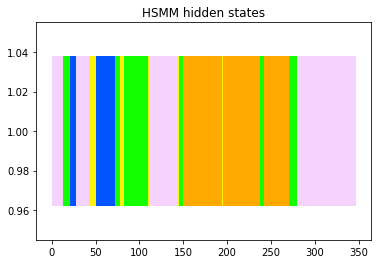

In [103]:
n = len(transformed_states[1])
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

# set up colors 
c = [state_color_dict[x] for x in transformed_states[1]]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.title("HSMM hidden states")
plt.show()

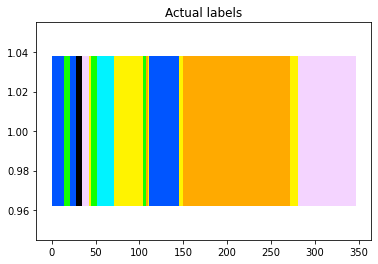

In [104]:
# construct some data
labels = features["p3"]["sternum"]["label"]
n = len(labels)
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

# set up colors 
c = [label_color_dict[x] for x in labels]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.title("Actual labels")
plt.show()

In [77]:
# PURPLE lab tasks
# PINK   lying
# BLUE   sitting
# CYAN   cycling
# GREEN  standing
# YELLOW moving around
# ORANGE walking
# RED    other activities
# BLACK  other events